In [1]:
import torch
import torch.nn as nn

import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("Using cuda")
else:
    print("Using cpu")

Using cuda


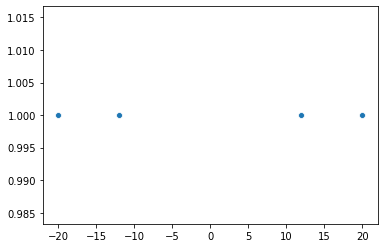

In [2]:
bad_samples = torch.cat([torch.arange(-20, 27, 8)[:2], torch.arange(-20, 27, 8)[4:]])


left_border, train_regions = -25, []
for k in range(bad_samples.shape[0]):
    train_regions.append([left_border, max(bad_samples[k].item() - 2.0, left_border)])
    left_border = bad_samples[k].item() + 2.0
train_regions.append([left_border, 25.0])
train_regions = torch.FloatTensor(train_regions)
sns.scatterplot(x=bad_samples, y=torch.ones_like(bad_samples))
plt.show()

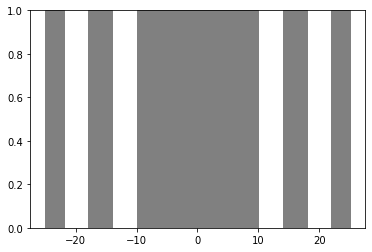

In [3]:
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey')
plt.show()

In [4]:
def target_pred(input):
    return torch.sin(input) + (input / 10.0)

def target_std(input):
    return 0.01 + 1 / (1 + torch.abs(input))

def get_gt_plot(n_samples=500):
    inp = torch.linspace(-25, 25, n_samples)
    return inp.numpy(), target_pred(inp).numpy()

def get_gt_stddev(n_samples=500):
    inp = torch.linspace(-25, 25, n_samples)
    return inp.numpy(), target_std(inp).numpy()

@torch.no_grad()
def get_model_plot(model, n_samples=500, device='cuda'):
    inp = torch.linspace(-25, 25, n_samples)
    return inp.numpy(), model(inp.to(device)).mean.squeeze().cpu().numpy()

@torch.no_grad()
def get_measure_plot(model, measure_n, n_samples=500, device='cuda', limits=25):
    inp = torch.linspace(-limits, limits, n_samples)
    measure_vals = getattr(model(inp.to(device)), measure_n)
    if callable(measure_vals):
        measure_vals = measure_vals()
    measure_vals = measure_vals.squeeze()
    if 'variance' in measure_n:
        measure_vals = measure_vals ** 0.5
    return inp.numpy(), measure_vals.cpu().numpy()

def toy_data_loader(bs=64, train=True):
    for _ in range(64):
        rand_x = torch.zeros((bs, 1)).uniform_(-25, 25)
        if train:
            rand_regions = train_regions[torch.randint(0, len(train_regions), (bs,))]
            frac = ((rand_x + 25.0) / 50.0)[:, 0]
            rand_x = (rand_regions[:, 0] * frac + rand_regions[:, 1] * (1 - frac)).unsqueeze(1)
        gt_noices = torch.randn_like(rand_x) if train else torch.zeros_like(rand_x)
        rand_y = target_pred(rand_x) + target_std(rand_x) * gt_noices
        yield rand_x, rand_y

In [5]:
trainloader, testloader = toy_data_loader(), toy_data_loader(train=False)

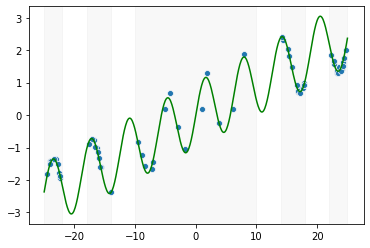

In [6]:
ex_x, ex_y = next(iter(trainloader))
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey', alpha=0.05)
sns.scatterplot(x=ex_x.squeeze(), y=ex_y.squeeze())
plt.plot(*get_gt_plot(), color='green')
plt.show()

In [20]:
from torch.optim import Adam
from distributions.distribution_wrappers import ProbabilisticWrapper
from torch.distributions.normal import Normal
from models.simple_model import SimpleModel

from training.distribution_trainer import NLLSingleDistributionTrainer

class ToyNLLTrainer(NLLSingleDistributionTrainer):
    def logging_step(self, val_loader, current_step,
        current_epoch, step_idx, steps_per_epoch
    ):
        pass
    def eval_step(self, val_loader, current_step, current_epoch):
        pass

model = SimpleModel(1, 1, 200, num_hidden=6, activation=nn.ELU).cuda()
model = ProbabilisticWrapper(Normal, model)

trainer = ToyNLLTrainer(
    model, Adam, lambda logdir: logdir, 'none',
    600, {"lr": 1e-3, "warmup_steps": 600}
)
trainer.train(list(toy_data_loader()), testloader)

Starting training for 38400 steps


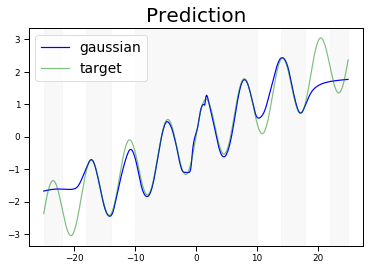

In [23]:
sns.set_context("paper")
#trainloader, testloader = toy_data_loader(), toy_data_loader(train=False)
ex_x, ex_y = next(iter(testloader))
plt.title("Prediction", fontsize=20)
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey', alpha=0.05)
res = get_model_plot(model)
sns.lineplot(x=res[0], y=res[1], color='blue', label='gaussian')
orig = get_gt_plot()
sns.lineplot(x=orig[0], y=orig[1], color='green', label='target', alpha=0.5)
plt.legend(fontsize='x-large', title_fontsize='40', loc='upper left')
plt.show()

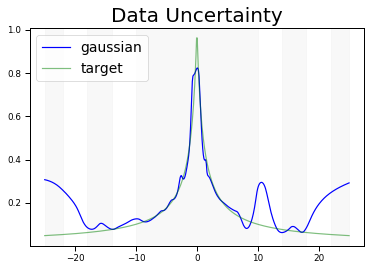

In [24]:
plt.title("Data Uncertainty", fontsize=20)
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey', alpha=0.05)

res = get_measure_plot(model, 'stddev')
sns.lineplot(x=res[0], y=res[1], color='blue', label='gaussian')
orig = get_gt_stddev()
sns.lineplot(x=orig[0], y=orig[1], color='green', label='target', alpha=0.5)
plt.legend(fontsize='x-large', title_fontsize='40', loc='upper left')
plt.show()

In [25]:
gaussian_models = [model]
for k in range(4):
    print("Training model %d..." % k)
    new_model = SimpleModel(1, 1, 200, num_hidden=6, activation=nn.ELU).cuda()
    new_model = ProbabilisticWrapper(Normal, new_model)
    trainer = ToyNLLTrainer(new_model, Adam, lambda logdir: logdir, 'none', 600, {"lr": 1e-3, "warmup_steps": 600})
    trainer.train(list(toy_data_loader()), testloader)
    gaussian_models.append(new_model)
    print("Done!")

Training model 0...
Starting training for 38400 steps



Done!
Training model 1...
Starting training for 38400 steps



Done!
Training model 2...
Starting training for 38400 steps



Done!
Training model 3...
Starting training for 38400 steps



Done!


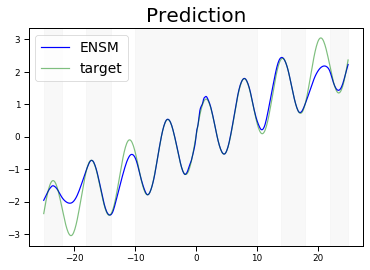

In [26]:
from distributions.distribution_wrappers import GaussianEnsembleWrapper

ens_model = GaussianEnsembleWrapper([m.model for m in gaussian_models])
plt.title("Prediction", fontsize=20)
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey', alpha=0.05)
res = get_model_plot(ens_model)
sns.lineplot(x=res[0], y=res[1], color='blue', label='ENSM')
orig = get_gt_plot()
sns.lineplot(x=orig[0], y=orig[1], color='green', label='target', alpha=0.5)
plt.legend(fontsize='x-large', title_fontsize='40', loc='upper left')
plt.show()

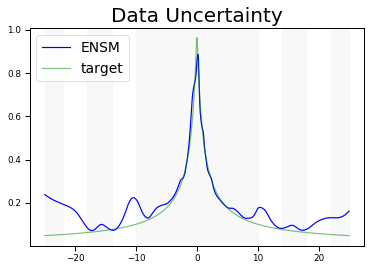

In [28]:
plt.title("Data Uncertainty", fontsize=20)
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey', alpha=0.05)

res = get_measure_plot(ens_model, 'expected_variance')
sns.lineplot(x=res[0], y=res[1], color='blue', label='ENSM')
orig = get_gt_stddev()
sns.lineplot(x=orig[0], y=orig[1], color='green', label='target', alpha=0.5)
plt.legend(fontsize='x-large', title_fontsize='40', loc='upper left')
plt.show()

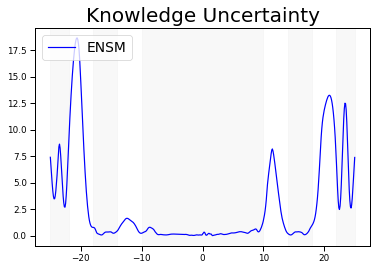

In [31]:
plt.title("Knowledge Uncertainty", fontsize=20)
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey', alpha=0.05)

res = get_measure_plot(ens_model, 'expected_pairwise_kl', limits=25)
sns.lineplot(x=res[0], y=res[1], color='blue', label='ENSM')
plt.legend(fontsize='x-large', title_fontsize='40', loc='upper left')
plt.show()

In [32]:
from distributions.nw_prior import NormalWishartPrior
from training.distillation_trainer import DistillationTrainer

class ToyDistillationTrainer(DistillationTrainer):
    def logging_step(self, val_loader, current_step,
        current_epoch, step_idx, steps_per_epoch
    ):
        pass
    def eval_step(self, val_loader, current_step, current_epoch):
        pass

endd_model = ProbabilisticWrapper(NormalWishartPrior, SimpleModel(1, 1, 200, out_channels=3,
                                                                  num_hidden=6, activation=nn.ELU).cuda())

trainer = ToyDistillationTrainer(
    ens_model, 10.0, endd_model, Adam, lambda logdir: logdir, 
    'none', 600, {"lr": 1e-3, "warmup_steps": 600}
)
trainer.train(list(toy_data_loader()), testloader)

Starting training for 38400 steps


In [36]:
end_model = ProbabilisticWrapper(Normal, SimpleModel(1, 1, 200, out_channels=2,
                                                                  num_hidden=6, activation=nn.ELU).cuda())

trainer = ToyDistillationTrainer(
    ens_model, 10.0, end_model, Adam, lambda logdir: logdir, 
    'none', 600, {"lr": 1e-3, "warmup_steps": 600}
)
trainer.train(list(toy_data_loader()), testloader)

Starting training for 38400 steps


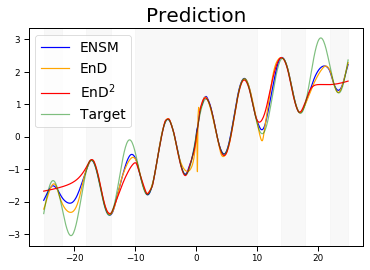

In [49]:
from distributions.distribution_wrappers import GaussianEnsembleWrapper

ens_model = GaussianEnsembleWrapper([m.model for m in gaussian_models])
plt.title("Prediction", fontsize=20)
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey', alpha=0.05)
res = get_model_plot(ens_model)
sns.lineplot(x=res[0], y=res[1], color='blue', label='ENSM')
res = get_model_plot(end_model)
sns.lineplot(x=res[0], y=res[1], color='orange', label='EnD')
res = get_model_plot(endd_model)
sns.lineplot(x=res[0], y=res[1], color='red', label='EnD$^2$')
orig = get_gt_plot()
sns.lineplot(x=orig[0], y=orig[1], color='green', label='Target', alpha=0.5)
plt.legend(fontsize='x-large', title_fontsize='40', loc='upper left')
plt.savefig("Prediction.png", dpi=300, tight_layout=True)

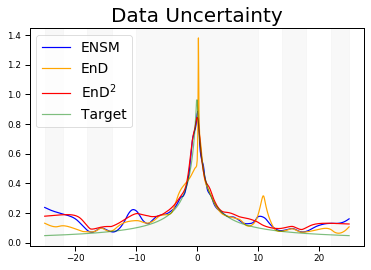

In [50]:
plt.title("Data Uncertainty", fontsize=20)
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey', alpha=0.05)

res = get_measure_plot(ens_model, 'expected_variance')
sns.lineplot(x=res[0], y=res[1], color='blue', label='ENSM')
res = get_measure_plot(end_model, 'variance')
sns.lineplot(x=res[0], y=res[1], color='orange', label='EnD')
res = get_measure_plot(endd_model, 'expected_variance')
sns.lineplot(x=res[0], y=res[1], color='red', label='EnD$^2$')
orig = get_gt_stddev()
sns.lineplot(x=orig[0], y=orig[1], color='green', label='Target', alpha=0.5)
plt.legend(fontsize='x-large', title_fontsize='40', loc='upper left')
plt.savefig("Data_Uncertainty.png", dpi=300, tight_layout=True)

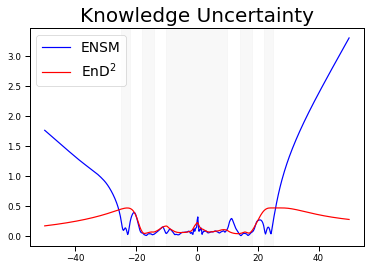

In [51]:
plt.title("Knowledge Uncertainty", fontsize=20)
for r in train_regions:
    plt.axvspan(r[0], r[1], color='grey', alpha=0.05)

res = get_measure_plot(ens_model, 'variance_of_expected', limits=50)
sns.lineplot(x=res[0], y=res[1], color='blue', label='ENSM')
#res = get_measure_plot(end_model, 'variance', limits=30)
#sns.lineplot(x=res[0], y=res[1], color='orange', label='EnD')
res = get_measure_plot(endd_model, 'variance_of_expected', limits=50)
sns.lineplot(x=res[0], y=res[1], color='red', label='EnD$^2$')
plt.legend(fontsize='x-large', title_fontsize='40', loc='upper left')
plt.savefig("Knowledge_Uncertainty.png", dpi=300, tight_layout=True)